In [1]:
%matplotlib inline

import math, time, random, datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier

from sklearn.tree import DecisionTreeClassifier

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
gender_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


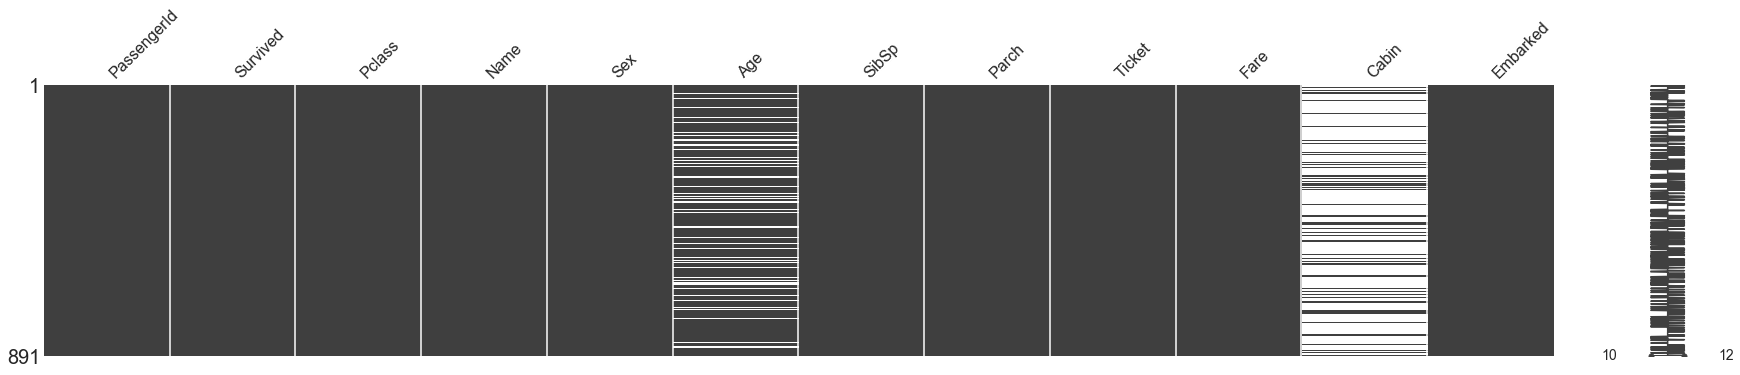

In [8]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,5))

In [9]:
#count of missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## EDA

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


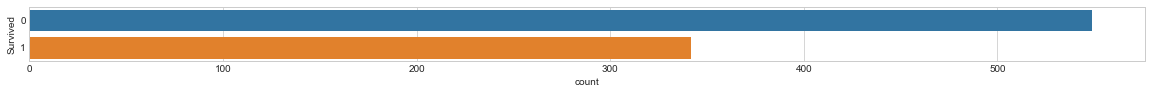

In [13]:
# How many people survived?  
#0 = No, 1 = Yes
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [14]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [15]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [16]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


## pclass: Ticket class.

A proxy for socio-economic status (SES)

1st = Upper 2nd = Middle 3rd = Lower

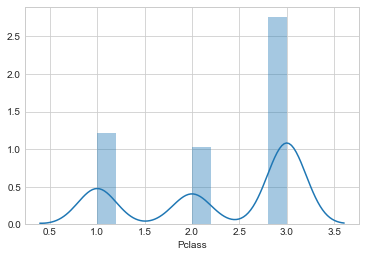

In [17]:
sns.distplot(train.Pclass)

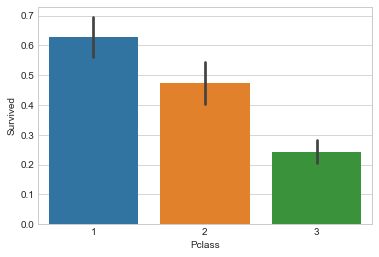

In [18]:
sns.barplot(x='Pclass', y='Survived', data=train)

In [19]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [20]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

## Name

Description: The name of the passenger.


In [21]:
train.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [22]:
data = [train]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)


In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


## Sex

Description: The sex of the passenger (male or female).

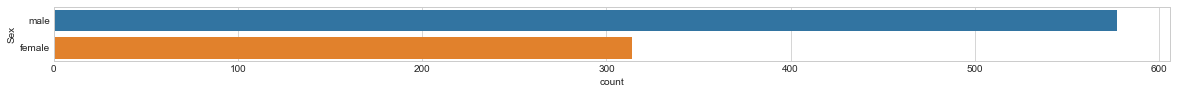

In [24]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 1))
sns.countplot(y="Sex", data=train);

In [25]:
train.Sex.isnull().sum()

0

In [26]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_con['Sex'] = train['Sex']
df_bin['Sex_Var'] = np.where(df_bin['Sex'] == 'female', 1, 0)

In [27]:
df_bin['Male'] = [1 if s=="male" else 0 for s in train.Sex]

In [28]:
df_bin['Female']=[1 if s=="female" else 0 for s in train.Sex]

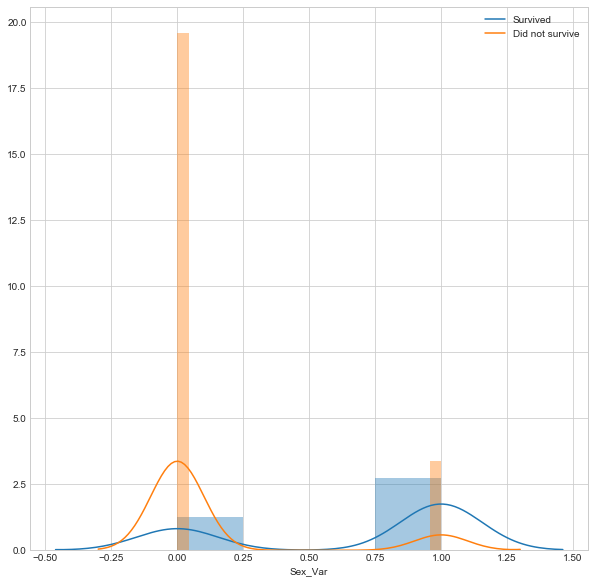

In [29]:
# How does the Sex variable look compared to Survival?
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex_Var'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex_Var'], kde_kws={'label': 'Did not survive','bw':0.1});

Text(0.5, 1.0, 'Male')

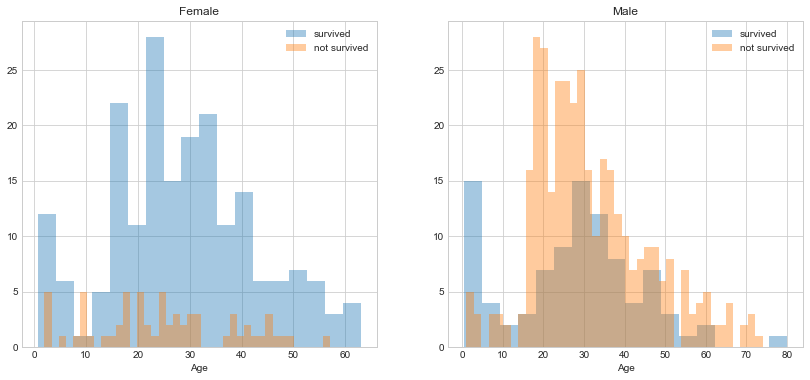

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,6))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = 'not survived', ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = 'survived', ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = 'not survived', ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male')

In [31]:
data = [train, test]

for dataset in data:
    mean = train["Age"].mean()
    std = test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)
    
train["Age"].isnull().sum()


0

In [32]:
test['Age'].isnull().sum()

0

In [33]:
df_bin['Age'] = train['Age']
df_con['Age'] = train['Age']

# SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic

In [34]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [35]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [36]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

In [37]:
df_bin.head()

,Survived,Pclass,Sex,Sex_Var,Male,Female,Age,SibSp
0,0,3,male,0,1,0,22,1
1,1,1,female,1,0,1,38,1
2,1,3,female,1,0,1,26,0
3,1,1,female,1,0,1,35,1
4,0,3,male,0,1,0,35,0


# Parch

Description: The number of parents/children the passenger has aboard the Titanic.

In [40]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [41]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [42]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

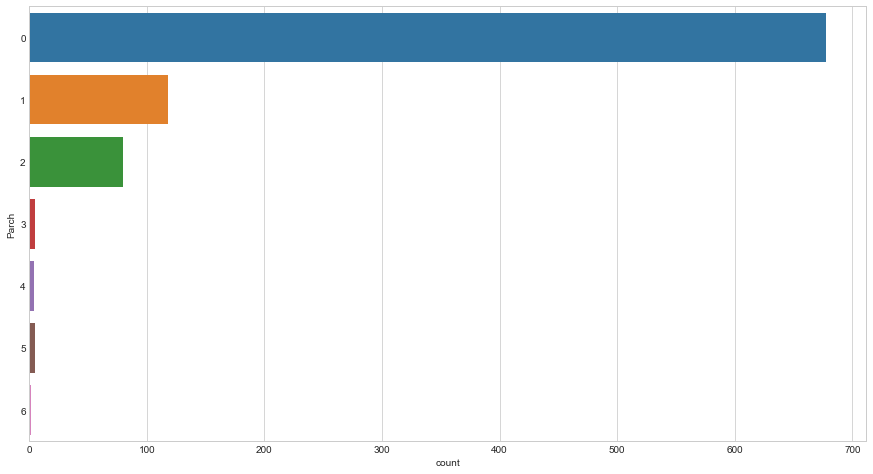

In [43]:
fig = plt.figure(figsize=(15,8))
sns.countplot(y='Parch', data=df_bin)

## Ticket

Description: The ticket number of the boarding passenger.

In [44]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

In [45]:
# How many unique kinds of Tickets are there?
train.Ticket.describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

# Fare

Description: How much the ticket cost.


In [46]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

In [47]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


In [48]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [49]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1


In [50]:
df_bin.head()

,Survived,Pclass,Sex,Sex_Var,Male,Female,Age,SibSp,Parch,Fare
0,0,3,male,0,1,0,22,1,0,"(-0.512, 102.466]"
1,1,1,female,1,0,1,38,1,0,"(-0.512, 102.466]"
2,1,3,female,1,0,1,26,0,0,"(-0.512, 102.466]"
3,1,1,female,1,0,1,35,1,0,"(-0.512, 102.466]"
4,0,3,male,0,1,0,35,0,0,"(-0.512, 102.466]"


In [51]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

# Cabin

Description: The cabin number where the passenger was staying.


In [53]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [54]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1


In [55]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train,test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [56]:
# Add Deck to sub dataframes
df_bin['Deck'] = train['Deck']
df_con['Deck'] = train['Deck']

# Embarked

Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [57]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [58]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [59]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [60]:
# Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.
common_value = 'S'
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [61]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [62]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked
0,0,3,male,22,1,0,7.2500,8,S
1,1,1,female,38,1,0,71.2833,3,C
2,1,3,female,26,0,0,7.9250,8,S
3,1,1,female,35,1,0,53.1000,3,S
4,0,3,male,35,0,0,8.0500,8,S


## Encoding

In [63]:
df_bin.head()

,Survived,Pclass,Sex,Sex_Var,Male,Female,Age,SibSp,Parch,Fare,Deck,Embarked
0,0,3,male,0,1,0,22,1,0,"(-0.512, 102.466]",8,S
1,1,1,female,1,0,1,38,1,0,"(-0.512, 102.466]",3,C
2,1,3,female,1,0,1,26,0,0,"(-0.512, 102.466]",8,S
3,1,1,female,1,0,1,35,1,0,"(-0.512, 102.466]",3,S
4,0,3,male,0,1,0,35,0,0,"(-0.512, 102.466]",8,S


In [64]:
df_bin.columns

Index(['Survived', 'Pclass', 'Sex', 'Sex_Var', 'Male', 'Female', 'Age',
       'SibSp', 'Parch', 'Fare', 'Deck', 'Embarked'],
      dtype='object')

In [65]:
# One-hot encode binned variables
one_hot_cols = ['Pclass','SibSp', 'Parch', 'Fare', 'Deck', 'Embarked']
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Sex,Sex_Var,Male,Female,Age,Pclass_1,Pclass_2,Pclass_3,SibSp_0,...,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Embarked_C,Embarked_Q,Embarked_S
0,0,male,0,1,0,22,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,1,female,1,0,1,38,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,female,1,0,1,26,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
3,1,female,1,0,1,35,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,male,0,1,0,35,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1


In [66]:
df_con.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Deck,Embarked
0,0,3,male,22,1,0,7.2500,8,S
1,1,1,female,38,1,0,71.2833,3,C
2,1,3,female,26,0,0,7.9250,8,S
3,1,1,female,35,1,0,53.1000,3,S
4,0,3,male,35,0,0,8.0500,8,S
5,0,3,male,18,0,0,8.4583,8,Q
6,0,1,male,54,0,0,51.8625,5,S
7,0,3,male,2,3,1,21.0750,8,S
8,1,3,female,27,0,2,11.1333,8,S
9,1,2,female,14,1,0,30.0708,8,C


In [67]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [68]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [69]:
# Let's look at df_con_enc
df_con_enc.head(10)

,Survived,Age,SibSp,Parch,Fare,Deck,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22,1,0,7.2500,8,0,0,1,0,1,0,0,1
1,1,38,1,0,71.2833,3,1,0,0,1,0,1,0,0
2,1,26,0,0,7.9250,8,0,0,1,1,0,0,0,1
3,1,35,1,0,53.1000,3,0,0,1,1,0,1,0,0
4,0,35,0,0,8.0500,8,0,0,1,0,1,0,0,1
5,0,18,0,0,8.4583,8,0,1,0,0,1,0,0,1
6,0,54,0,0,51.8625,5,0,0,1,0,1,1,0,0
7,0,2,3,1,21.0750,8,0,0,1,0,1,0,0,1
8,1,27,0,2,11.1333,8,0,0,1,1,0,0,0,1
9,1,14,1,0,30.0708,8,1,0,0,1,0,0,1,0


##  Building Machine Learning Models

In [70]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [71]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [72]:
# Shape of the data (without labels)
X_train.shape

(891, 13)

In [73]:
# Shape of the labels
y_train.shape

(891,)

In [74]:
X_train.head()

,Age,SibSp,Parch,Fare,Deck,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22,1,0,7.2500,8,0,0,1,0,1,0,0,1
1,38,1,0,71.2833,3,1,0,0,1,0,1,0,0
2,26,0,0,7.9250,8,0,0,1,1,0,0,0,1
3,35,1,0,53.1000,3,0,0,1,1,0,1,0,0
4,35,0,0,8.0500,8,0,0,1,0,1,0,0,1


### Linear Regression

In [75]:
# Logistic Regression
start_time = time.time()

lr_model = LogisticRegression()

lr_model.fit(X_train, y_train)

acc_log = round(lr_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_log = model_selection.cross_val_predict(lr_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_log = round(metrics.accuracy_score(y_train, train_pred_log) * 100, 2)

log_time = (time.time() - start_time)

print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.47
Accuracy CV 10-Fold: 79.69
Running Time: 0:00:02.151973


### Gaussian Naive Bayes

In [76]:
# Gaussian Naive Bayes
start_time = time.time()

gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train)

acc_gaussian = round(gnb_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_gaussian = model_selection.cross_val_predict(gnb_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_gaussian = round(metrics.accuracy_score(y_train, train_pred_gaussian) * 100, 2)

log_time = (time.time() - start_time)

gaussian_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 77.55
Accuracy CV 10-Fold: 76.99
Running Time: 0:00:00.048901


## K-Nearest Neighbour

In [77]:
# k-Nearest Neighbours
start_time = time.time()

knn_model = KNeighborsClassifier(n_neighbors = 3)

knn_model.fit(X_train, y_train)

acc_knn = round(knn_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_knn = model_selection.cross_val_predict(knn_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_knn = round(metrics.accuracy_score(y_train, train_pred_knn) * 100, 2)

knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 84.18
Accuracy CV 10-Fold: 71.49
Running Time: 0:00:00.127059


### Stochastic Gradient Descent

In [78]:
# Stochastic Gradient Descent
start_time = time.time()

sgd_model = SGDClassifier()

sgd_model.fit(X_train, y_train)

acc_sgd = round(sgd_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_sgd = model_selection.cross_val_predict(sgd_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_sgd = round(metrics.accuracy_score(y_train, train_pred_sgd) * 100, 2)

sgd_time = (time.time() - start_time)

print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 75.08
Accuracy CV 10-Fold: 70.03
Running Time: 0:00:00.045403


### Decision Tree Classifier

In [79]:
# Decision Tree Classifier
start_time = time.time()

dt_model = DecisionTreeClassifier()

dt_model.fit(X_train, y_train)

acc_dt = round(gnb_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_dt = model_selection.cross_val_predict(dt_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_dt = round(metrics.accuracy_score(y_train, train_pred_dt) * 100, 2)

dt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 77.55
Accuracy CV 10-Fold: 79.24
Running Time: 0:00:00.056361


### Gradient Boosting Algorithm

In [80]:
# Gradient Boosting Trees
start_time = time.time()

gbt_model = GradientBoostingClassifier()

gbt_model.fit(X_train, y_train)

acc_gbt = round(gnb_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_gbt = model_selection.cross_val_predict(gbt_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_gbt = round(metrics.accuracy_score(y_train, train_pred_gbt) * 100, 2)

gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 77.55
Accuracy CV 10-Fold: 82.83
Running Time: 0:00:00.451791


### Random Forest Algorithm

In [81]:
# Random Forest Trees
start_time = time.time()

rft_model = RandomForestClassifier()

rft_model.fit(X_train, y_train)

acc_rft = round(rft_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_rft = model_selection.cross_val_predict(rft_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_rft = round(metrics.accuracy_score(y_train, train_pred_rft) * 100, 2)


rft_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rft)
print("Accuracy CV 10-Fold: %s" % acc_cv_rft)
print("Running Time: %s" % datetime.timedelta(seconds=rft_time))

Accuracy: 98.65
Accuracy CV 10-Fold: 81.71
Running Time: 0:00:00.729568


### Linear Support Vector Machines (SVC)

In [82]:
# Linear SVC
start_time = time.time()

svc_model = LinearSVC()

svc_model.fit(X_train, y_train)

acc_linear_svc = round(svc_model.score(X_train, y_train) * 100, 2)
    
# Cross Validation 
train_pred_svc = model_selection.cross_val_predict(svc_model,X_train,y_train,cv=10,n_jobs = -1)

# Cross-validation accuracy metric
acc_cv_linear_svc =round(metrics.accuracy_score(y_train, train_pred_svc) * 100, 2)

linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 73.63
Accuracy CV 10-Fold: 73.18
Running Time: 0:00:00.211434


### Model Results

### Regular accuracy scores

In [83]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'RandomForestClassifier'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_rft
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
7,RandomForestClassifier,98.65
0,KNN,84.18
1,Logistic Regression,80.47
2,Naive Bayes,77.55
5,Decision Tree,77.55
6,Gradient Boosting Trees,77.55
3,Stochastic Gradient Decent,75.08
4,Linear SVC,73.63


### Cross-validation Accuracy Scores

In [84]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'RandomForestClassifier'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_rft
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,82.83
7,RandomForestClassifier,81.71
1,Logistic Regression,79.69
5,Decision Tree,79.24
2,Naive Bayes,76.99
4,Linear SVC,73.18
0,KNN,71.49
3,Stochastic Gradient Decent,70.03


### Feature Importance

Which features of the best model were most important for making predictions?


In [85]:
# Feature Importance
def feature_importance(model, data):
    
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
6,0.001228,embarked_Q
11,0.001606,pclass_2
10,0.002661,pclass_1
5,0.003463,embarked_C
2,0.003865,Parch
7,0.014350,embarked_S
1,0.045220,SibSp
4,0.052314,Deck
12,0.121881,pclass_3
0,0.131081,Age


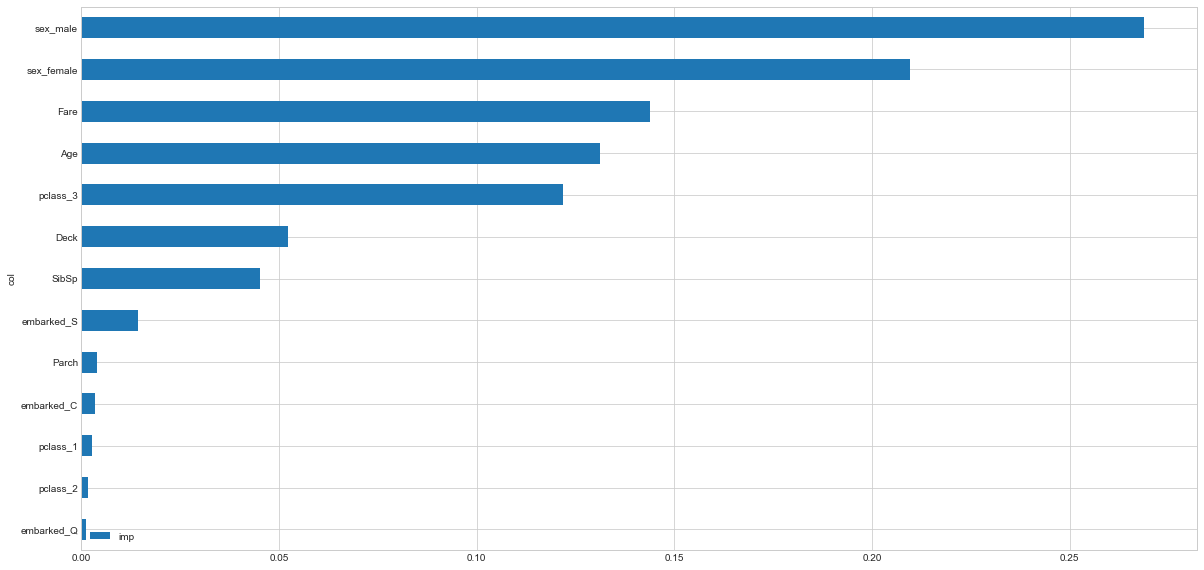

In [86]:
# Plot the feature importance scores
feature_importance(gbt_model, X_train)

,imp,col
6,0.008721,embarked_Q
5,0.011482,embarked_C
7,0.015732,embarked_S
11,0.017399,pclass_2
10,0.019019,pclass_1
2,0.035251,Parch
1,0.042813,SibSp
12,0.046179,pclass_3
4,0.057464,Deck
8,0.108385,sex_female


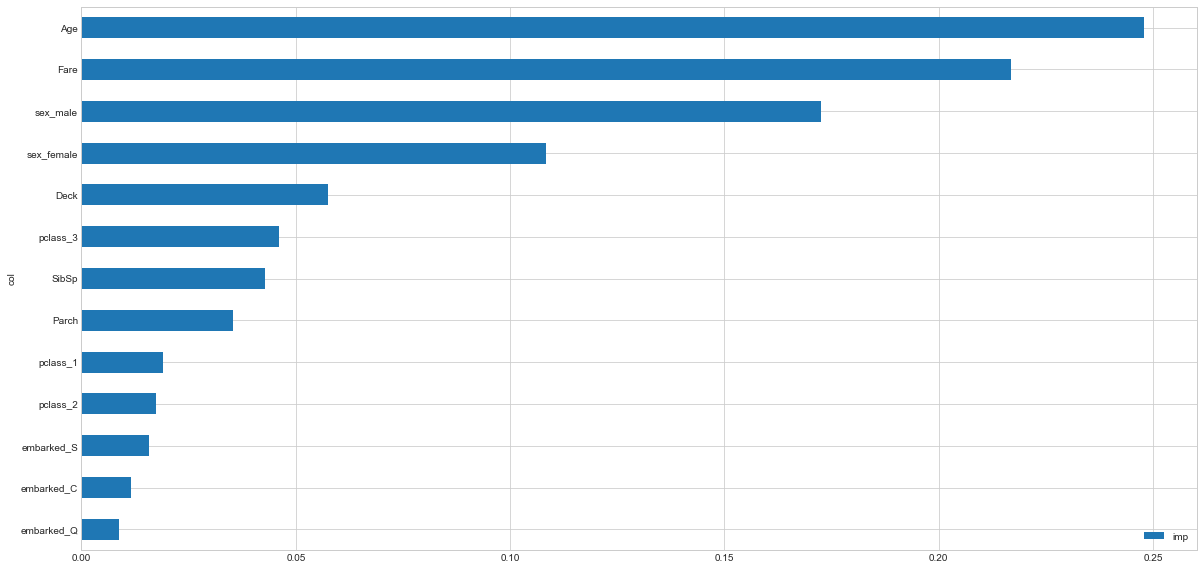

In [87]:
feature_importance(rft_model,X_train)

### Submission

In [88]:
# We need our test dataframe to look like this one
X_train.head()

,Age,SibSp,Parch,Fare,Deck,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22,1,0,7.2500,8,0,0,1,0,1,0,0,1
1,38,1,0,71.2833,3,1,0,0,1,0,1,0,0
2,26,0,0,7.9250,8,0,0,1,1,0,0,0,1
3,35,1,0,53.1000,3,0,0,1,1,0,1,0,0
4,35,0,0,8.0500,8,0,0,1,0,1,0,0,1


In [89]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,U0,Q,8
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,U0,S,8
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,U0,Q,8
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,U0,S,8
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,U0,S,8


In [90]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [91]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [92]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,U0,Q,8,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,U0,S,8,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,U0,Q,8,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,U0,S,8,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,U0,S,8,0,0,1,1,0,0,0,1


In [93]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Deck', 'embarked_C',
       'embarked_Q', 'embarked_S', 'sex_female', 'sex_male', 'pclass_1',
       'pclass_2', 'pclass_3'],
      dtype='object')

In [94]:
 X_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Deck', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sex_female', 'sex_male', 'pclass_1', 'pclass_2',
       'pclass_3'],
      dtype='object')

In [95]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns.tolist()
X_test = test[wanted_test_columns]
X_test.head()

,Age,SibSp,Parch,Fare,Deck,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,34,0,0,7.8292,8,0,1,0,0,1,0,0,1
1,47,1,0,7.0000,8,0,0,1,1,0,0,0,1
2,62,0,0,9.6875,8,0,1,0,0,1,0,1,0
3,27,0,0,8.6625,8,0,0,1,0,1,0,0,1
4,22,1,1,12.2875,8,0,0,1,1,0,0,0,1


In [96]:
X_test.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          1
Deck          0
embarked_C    0
embarked_Q    0
embarked_S    0
sex_female    0
sex_male      0
pclass_1      0
pclass_2      0
pclass_3      0
dtype: int64

In [97]:
X_test['Fare'] = X_test['Fare'].fillna(0)
X_test['Fare'] = X_test['Fare'].astype(int)


In [100]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = rft_model.predict(X_test)

In [101]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [102]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [103]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [105]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [106]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [107]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [109]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../rft_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [110]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../rft_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
